# Affirmation Sample selection

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import os
from os.path import join
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.fitting.optimizer import get_spirals, Optimizer
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
from gzbuilder_analysis.aggregation.spirals import inclined_log_spiral
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.jax.sersic import _b, sersic_ltot
import gzbuilder_analysis.fitting as fitting
from gzbuilder_analysis.fitting.reparametrization import from_reparametrization
import gzbuilder_analysis.fitting.jax as fjx
from gzbuilder_analysis.fitting.misc import df_to_dict
from asinh_cmap import asinh_cmap
from astropy.visualization import AsinhStretch
import lib.galaxy_utilities as gu

In [167]:
fm = pd.read_pickle('lib/fitting_metadata.pkl')
gal_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
nsa_df = pd.read_pickle('lib/df_nsa.pkl').set_index('NSAID', drop=False)

In [168]:
import warnings
warnings.simplefilter('ignore', UserWarning)
agg_res_path = 'output_files/aggregation_results_affirmation'
agg_results = pd.Series([], dtype=object)
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(join(agg_res_path, f))

100%|██████████| 10/10 [00:00<00:00, 25.06it/s]


In [169]:
# All of these functions are taken from gzbuilder_data_prep, *with modifications* so we don't recalculate anything
from PIL import Image

# from createSubjectsFunctions
def stretchArray(arr, a=0.1):
    # shift so lowest value = 0
    shiftedArr = arr - np.amin(arr)
    # normalise from 0 to 1
    normalisedArr = shiftedArr / np.amax(shiftedArr)
    # perform the stretch
    arrOut = np.arcsinh(normalisedArr / a) / np.arcsinh(1 / a)
    return arrOut


def saveImage(
        arr, fname='testImage.png', resize=False, size=(512, 512),
        preserveAspectRatio=True, resample=Image.LANCZOS, verbose=False):
    # ensure image is normalised to [0, 255]
    arr = (arr.transpose() - np.amin(arr)) / np.amax(arr - np.amin(arr)) * 255
    # cast to uint8 with a weird coordinate swap (idk why)
    im = Image.fromarray(
        np.uint8(np.flipud(np.swapaxes(np.flipud(arr), 0, 1)))
    )
    # want to preserve aspect ratio, so increase the width to provided width
    if preserveAspectRatio:
        correctedSize = (size[0], int(im.size[1] / im.size[0] * size[0]))
    else:
        correctedSize = size[:]
    if resize:
        im = im.resize(correctedSize, resample)
    im.save(fname)
    return im


# from subjectCreator
def makeModel(imageData, psf, resizeTo=(512, 512)):
    return {
        'psf': psf.tolist(),
        'psfWidth': psf.shape[1],
        'psfHeight': psf.shape[0],
        'width': imageData.shape[1],
        'height': imageData.shape[0],
        'imageWidth': resizeTo[0],
        'imageHeight': int(
            imageData.shape[0] / imageData.shape[1] * resizeTo[0]
        )
    }


def makeDifference(imageData, psf, mask, resizeTo=(512, 512)):
    return {
        'psf': psf.tolist(),
        'psfWidth': psf.shape[1],
        'psfHeight': psf.shape[0],
        'mask': np.array(mask, dtype=float).tolist(),
        'imageData': imageData.tolist(),
        'multiplier': 1,
        'width': imageData.shape[1],
        'height': imageData.shape[0],
        'imageWidth': resizeTo[0],
        'imageHeight': int(
            imageData.shape[0] / imageData.shape[1] * resizeTo[0]
        ),
    }


def makeMetadata(galObj, extra_metadata={}):
    return {
        'ra': '{:05f}'.format(galObj['RA']),
        'dec': '{:05f}'.format(galObj['DEC']),
        'redshift': '{:05f}'.format(galObj['Z']),
        'SDSS dr7 id': str(galObj['dr7objid']),
        'Common name': (
            str(galObj['IAUNAME'])
            if galObj['IAUNAME'] else 'Unknown'
        ),
        'NSA id': str(galObj['NSAID']),
        'Estimated distance': '{} * c / H_0'.format(galObj['ZDIST']),
        'Petrosian radius (degrees)': '{:05f}'.format(galObj['PETRO_THETA']),
        'Run': str(galObj['RUN']),
        'Camcol': str(galObj['CAMCOL']),
        'Field': str(galObj['FIELD']),
        'Rerun': str(galObj['RERUN']),
        'Sersic axis ratio': '{:05f}'.format(galObj['SERSIC_BA']),
        'Url to view': "[View on SkyServer](+tab+http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra={ra}&dec={dec}&opt=F)".format(
            ra=float(galObj['RA']),
            dec=float(galObj['DEC'])
        ),
        '#isModelling': True,
        '#models': [
            {'frame': 0, 'model': 'GALAXY_BUILDER_DIFFERENCE'},
            {'frame': 2, 'model': 'GALAXY_BUILDER_MODEL'},
        ],
        **extra_metadata
    }


def pipeline(image_data, mask, psf, galObj, outputFolder, subjectName, extra_metadata={}, verbose=False):
    os.makedirs(outputFolder, exist_ok=True)

    maskedImageData = image_data.copy()
    maskedImageData[mask] = 0

    # generate the model json
    model = makeModel(maskedImageData, psf)

    # and the difference json
    difference = makeDifference(maskedImageData, psf, mask)

    # and the metadata
    metadata = makeMetadata(galObj, extra_metadata)

    # apply an asinh stretch and save the image to the outfolder
    resizeTo = (512, 512)
    saveImage(
        stretchArray(maskedImageData[:, ::-1]),
        fname="{}/image_{}.png".format(outputFolder, subjectName),
        resize=True,
        size=resizeTo
    )

    # now save the model json
    modelFileName = '{}/model_{}.json'.format(outputFolder, subjectName)
    with open(modelFileName, 'w') as f:
        json.dump(model, f)

    # write out the difference
    diffFileName = '{}/difference_{}.json'.format(outputFolder, subjectName)
    with open(diffFileName, 'w') as f:
        json.dump(difference, f)

    # and the metadata!
    metaFileName = '{}/metadata_{}.json'.format(outputFolder, subjectName)
    with open(metaFileName, 'w') as f:
        json.dump(metadata, f)

    return [
        "{}/image_{}.png".format(outputFolder, subjectName),
        modelFileName,
        diffFileName,
        metaFileName
    ]

In [ ]:
help(get_spirals)

In [171]:
def show_contours(model, idx, percentile=95, ax=None):
    if ax is not None:
        plt.sca(ax)
    shape = fm.loc[idx]['galaxy_data'].shape
    psf = fm.loc[idx]['psf']
    for i, c in enumerate(model.keys()):
        if model[c] is None or model[c] == {}:
            continue
        m = deepcopy(model)
        m = {k: (
            v
            if k == c or (c =='spiral' and k == 'disk')
            else (None if k != 'spiral' else [])
        )  for k, v in m.items()}
        if not all(v == None or v == [] for v in m.values()):
            if c == 'spiral' and m['disk'] is not None:
                m['disk']['I'] = 0
            r = rendering.calculate_model(m, image_size=shape, psf=psf)
            cs = plt.contour(
                r, levels=[np.percentile(r.ravel(), percentile)], colors=[f'C{i}'],
            )

def make_model(op):
    model = df_to_dict(from_reparametrization(op.model, op).unstack().T)
    arms = get_spirals(op.model.to_dict(), op.n_spirals, op.base_roll)
    model['spiral'] = [
        (np.array(arms[i]), dict(I=model['spiral'][f'I.{i}'], spread=model['spiral'][f'spread.{i}'], falloff=1))
        for i in range(op.n_spirals)
        # some arms may have gone to zero
        if f'I.{i}' in model['spiral']
    ]
    return {**dict(disk=None, bulge=None, bar=None, spiral=[]), **model}

def make_noisy(model, idx):
    shape = fm.loc[idx]['galaxy_data'].shape
    render = rendering.calculate_model(
        model, image_size=shape, psf=fm.loc[idx]['psf']
    )
    s = AsinhStretch()
    stretched_data = s(fm.loc[idx]['galaxy_data'])
    noisy_model = render + np.random.randn(*shape) * fm.loc[idx]['sigma_image']
    return noisy_model


def make_plot(op, idx, **kwargs):
    model = make_model(op)
    s = AsinhStretch()
    stretched_data = s(fm.loc[idx]['galaxy_data'])
    render = rendering.calculate_model(
        model, image_size=stretched_data.shape, psf=fm.loc[idx]['psf']
    )
    noisy_model = make_noisy(model, idx)
    stretched_noisy_model = s(noisy_model)
    lms = dict(
        vmin=min(stretched_data.min(), stretched_noisy_model.min()),
        vmax=max(stretched_data.max(), stretched_noisy_model.max())
    )
    _, ax = plt.subplots(ncols=4, figsize=(15, 8), dpi=100)
    ax[0].set_title('Reference galaxy')
    ax[0].imshow(stretched_data, cmap='gray_r', **lms)
    ax[1].set_title('Fake (Noisy)')
    ax[1].imshow(stretched_noisy_model, cmap='gray_r', **lms)
    ax[2].set_title('Residual')
    d = np.array(render) - fm.loc[idx]['galaxy_data']
    l = np.nanmax(np.abs(d))
    ax[2].imshow(
        np.array(render) - fm.loc[idx]['galaxy_data'],
        cmap='seismic',
        vmin=-l, vmax=l
    )
    ax[3].set_title('Fake (Contoured)')
    ax[3].imshow(
        s(render),
        cmap='gray_r',
        **lms
    )
    show_contours(model, idx, ax=ax[3], **kwargs)
    for a in ax:
        plt.sca(a)
        plt.axis('off')


def save_to_subject(op, idx, name):
    pd.to_pickle(dict(name=name, idx=idx, model=df_to_dict(from_reparametrization(op.model, op).unstack().T)), os.path.join('affirmation_set_models', f'{name}.pkl'))
    os.makedirs('affirmation_subjects', exist_ok=True)
    model = make_model(op)
    noisy_model = make_noisy(model, idx)

    galaxy_data = fm.loc[idx].galaxy_data
    psf = fm.loc[idx].psf
    galObj = nsa_df.loc[gal_df.loc[idx]['NSAID']]
    galObj.loc['dr7objid'] = gu.metadata.loc[idx]['SDSS dr7 id']
#     mtd = {'#isFake': True, '#subject_reference': idx}
#     return pipeline(noisy_model, galaxy_data.mask, psf, galObj, 'affirmation_subjects', name, extra_metadata=mtd, verbose=False)

In [172]:
# the way AggregationResult and Optimizer work have changed since uploading the subject set, this correction adds in the missing values
def legacy_correction(op, agr):
    return
    for i in range(len(agr.spiral_arms)):
        arm = agr.spiral_arms[i]
        op['spiral', f'I.{i}'] = agr.params[(f'spiral{i}', 'I')]
        op['spiral', f'spread.{i}'] = agr.params[(f'spiral{i}', 'spread')]
        op['spiral', f'falloff.{i}'] = agr.params[(f'spiral{i}', 'falloff')]
        op['spiral', f'A.{i}'] = arm.A
        op['spiral', f'phi.{i}'] = arm.pa * arm.chirality
        op['spiral', f't_min.{i}'] = arm.t_predict.min()
        op['spiral', f't_max.{i}'] = arm.t_predict.max()
    return op, agr

In [173]:
has_comp = agg_results.apply(
    lambda a: {k: True for k in a.model if a.model[k]}
).apply(pd.Series).fillna(False)
has_comp.describe().loc['freq'] / len(agg_results)

disk             1
bulge     0.555556
spiral    0.666667
bar       0.555556
Name: freq, dtype: object

## Single Exponential Disk model

In [47]:
has_comp.query('~spiral & ~bulge & ~bar');

/Users/tlingard/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


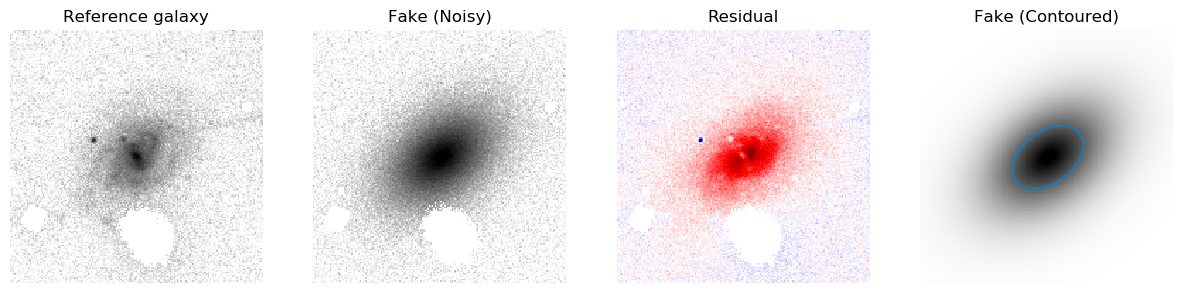

In [178]:
d_idx = 21686502
agr = agg_results.loc[d_idx]
o_d = Optimizer(agr, *fm.loc[d_idx][['psf', 'galaxy_data', 'sigma_image']])
o_d['disk', 'Re'] = o_d['disk', 'Re'] * 0.8
o_d['disk', 'L'] = o_d['disk', 'L'] * 0.8
make_plot(o_d, d_idx)
plt.savefig('affirmation_set_models/disk_model.png', bbox_inches='tight')
d_files = save_to_subject(o_d, d_idx, 'disk_model')

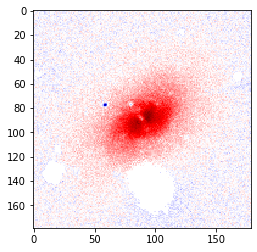

In [177]:
from gzbuilder_analysis.fitting.misc import _make_xy_arrays, downsample, psf_conv
original_model = pd.read_pickle('affirmation_set_models_old/disk_model.pkl')['model']
foo = pd.DataFrame(original_model).unstack().dropna()
foo[('disk', 'L')] = sersic_ltot(*foo['disk'][['I', 'Re', 'q']], 1, 2)
rendered_components = o_d.render_comps(foo)
psf, target, sigma = fm.loc[d_idx][['psf', 'galaxy_data', 'sigma_image']]
d = np.array(psf_conv(sum(rendered_components.values()), psf)) - target
plt.imshow(d, vmin=-np.abs(d).max(), vmax=np.abs(d).max(), cmap='seismic')

## Exponential Disk + Sersic Bulge model

In [131]:
has_comp.query('~spiral & bulge & ~bar');

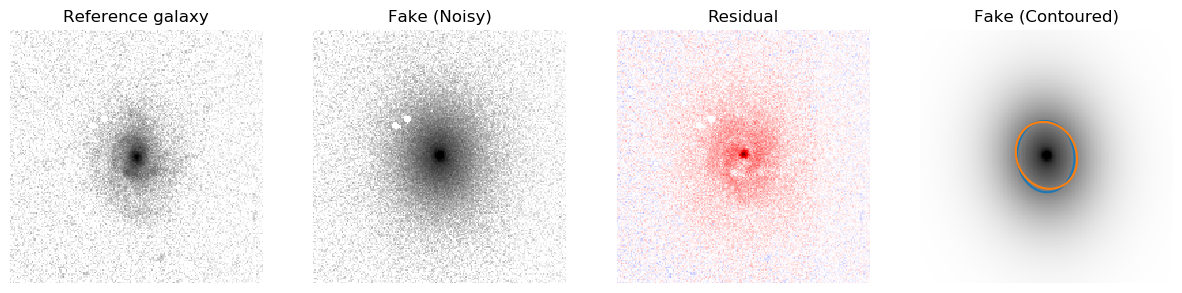

In [132]:
db_idx = 21686588
agr = agg_results.loc[db_idx]
o_db = Optimizer(agr, *fm.loc[db_idx][['psf', 'galaxy_data', 'sigma_image']])
o_db['disk', 'L'] = sersic_ltot(
    bad_sersic_I(o_db['disk', 'L'] * 0.8, o_db['disk', 'Re'], o_db.model.get(('disk', 'n'), 1)),
    o_db['disk', 'Re'],
    o_db['disk', 'q'],
    n=o_db.model.get(('disk', 'n'), 1),
    c=o_db.model.get(('disk', 'c'), 2)
)
o_db['bulge', 'frac'] = 0.02
make_plot(o_db, db_idx)
plt.savefig('affirmation_set_models/disk_bulge_model.png', bbox_inches='tight')
db_files = save_to_subject(o_db, db_idx, 'disk_bulge_model')

In [ ]:
db2_idx = 20902038
agr = agg_results.loc[db2_idx]
o_db2 = Optimizer(agr, fm.loc[db2_idx])
o_db2['disk', 'Re'] *= 0.7
o_db2['disk', 'L'] *= 0.7**2
o_db2['bulge', 'frac'] = 0.7
o_db2['bulge', 'scale'] = 0.1
o_db2['bulge', 'n'] = 3
make_plot(o_db2, db2_idx)
plt.savefig('affirmation_set_models/disk_bulge_model2.png', bbox_inches='tight')
db2_files = save_to_subject(o_db2, db2_idx, 'disk_bulge_model2')

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar model

In [ ]:
has_comp.query('~spiral & bulge & bar');

In [ ]:
dbb_idx = 20902035
agr = agg_results.loc[dbb_idx]
o_dbb = Optimizer(agr, fm.loc[dbb_idx])
o_dbb['bulge', 'frac'] = 0.05
o_dbb['bar', 'c'] = 3
o_dbb['bar', 'q'] = 0.3
o_dbb['bar', 'frac'] = 0.07
o_dbb['bar', 'n'] = 0.6
o_dbb.n_spirals = 0
o_dbb.keys = [k for k in o_dbb.keys if k[0] != 'spiral']
o_dbb['spiral'] = {}
make_plot(o_dbb, dbb_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_model.png', bbox_inches='tight')
dbb_files = save_to_subject(o_dbb, dbb_idx, 'disk_bulge_bar_model')

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar + 2 Logarithmic spirals model

In [ ]:
has_comp.query('spiral & bulge & bar');

In [ ]:
# need correct for spiral spread reparametrization ( 1/(10x) => 1/(2*x**2) )
dbbs_idx = 21686529
agr = agg_results.loc[dbbs_idx]
o_dbbs = Optimizer(agr, fm.loc[dbbs_idx])

# coz I'm a twit
legacy_correction(o_dbbs, agr)

o_dbbs['disk', 'L'] *= 0.4
o_dbbs['bulge', 'frac'] = 0.02
o_dbbs['bar', 'frac'] = 0.2
o_dbbs['spiral', 'I.0'] = 0.02
o_dbbs['spiral', 'spread.0'] = np.sqrt(5 * 3)
o_dbbs['spiral', 'phi.0'] = 20
o_dbbs['spiral', 'A.0'] = 50
o_dbbs['spiral', 't_max.0'] = 0.7
o_dbbs['spiral', 'I.0'] = 0.04
o_dbbs['spiral', 'spread.1'] = np.sqrt(5 * 3)
o_dbbs['spiral', 'I.2'] = 0
make_plot(o_dbbs, dbbs_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_sp_model.png', bbox_inches='tight')
dbbs_files = save_to_subject(o_dbbs, dbbs_idx, 'disk_bulge_bar_sp_model')

# Exponential Disk + spirals model

In [ ]:
has_comp.query('spiral & ~bulge & ~bar');

In [ ]:
ds_idx = 20902055
agr = agg_results.loc[ds_idx]
o_ds = Optimizer(agr, fm.loc[ds_idx])

# coz I'm a twit
legacy_correction(o_ds, agr)

o_ds['disk', 'L'] *= 1.2

# need correct for spiral spread reparametrization ( 1/(10x) => 1/(2*x**2) )
for i in range(o_ds.n_spirals):
    o_ds['spiral', f'I.{i}'] *= 1.2
    ORIGINAL_SPREAD = 2
    o_ds['spiral', f'spread.{i}'] = np.sqrt(5 * ORIGINAL_SPREAD)
make_plot(o_ds, ds_idx)
plt.savefig('affirmation_set_models/disk_sp_model.png', bbox_inches='tight')
ds_files = save_to_subject(o_ds, ds_idx, 'disk_sp_model')

# Disk + Bulge + Spiral model

In [ ]:
has_comp.query('spiral & bulge & ~bar');

In [ ]:
dbs_idx = 20902067
agr = agg_results.loc[dbs_idx]
o_dbs = Optimizer(agr, fm.loc[dbs_idx])

# coz I'm a twit
legacy_correction(o_dbs, agr)

o_dbs['disk', 'L'] *= 0.5
o_dbs['disk', 'Re'] *= 0.8
o_dbs['bulge', 'frac'] = 0.02
o_dbs['bulge', 'scale'] = 0.05
# correct for spiral spread reparametrization
for i in range(o_dbs.n_spirals):
    ORIGINAL_SPREAD = 0.5
    o_dbs['spiral', f'spread.{i}'] = np.sqrt(5 * ORIGINAL_SPREAD)

make_plot(o_dbs, dbs_idx)
plt.savefig('affirmation_set_models/disk_bulge_sp_model.png', bbox_inches='tight')
dbs_files = save_to_subject(o_dbs, dbs_idx, 'disk_bulge_sp_model')

# Disk + Bar + Spiral model

In [ ]:
has_comp.query('spiral & ~bulge & bar');

In [ ]:
dbrs_idx = 20902006
agr = agg_results.loc[dbrs_idx]
o_dbrs = Optimizer(agr, fm.loc[dbrs_idx])

# coz I'm a twit
legacy_correction(o_dbrs, agr)

o_dbrs['disk', 'L'] *= 0.8
o_dbrs['bar', 'frac'] = 0.05
o_dbrs['bar', 'c'] = 4
o_dbrs['bar', 'n'] = 0.6
for i in range(o_dbrs.n_spirals):
    o_dbrs['spiral', f'I.{i}'] *= 1.2
    o_dbrs['spiral', f'spread.{i}'] = np.sqrt(5 * 2)
o_dbrs['spiral', 't_max.0'] -= np.pi/4
make_plot(o_dbrs, dbrs_idx)
plt.savefig('affirmation_set_models/disk_bar_sp_model.png', bbox_inches='tight')
dbrs_files = save_to_subject(o_dbrs, dbrs_idx, 'disk_bar_sp_model')

In [ ]:
dbrs2_idx = 21686576
agr = agg_results.loc[dbrs2_idx]
o_dbrs2 = Optimizer(agr, fm.loc[dbrs2_idx])

# coz I'm a twit
legacy_correction(o_dbrs2, agr)

o_dbrs2['bar', 'n'] = 0.8
o_dbrs2['bar', 'c'] = 3
o_dbrs2['bar', 'frac'] = 0.05
o_dbrs2['spiral', 'phi.0'] = 20
for i in range(o_dbrs2.n_spirals):
    o_dbrs2['spiral', f'spread.{i}'] = np.sqrt(5 * 0.5)
make_plot(o_dbrs2, dbrs2_idx)
plt.savefig('affirmation_set_models/disk_bar_sp_model2.png', bbox_inches='tight')
dbrs2_files = save_to_subject(o_dbrs2, dbrs2_idx, 'disk_bar_sp_model2')

In [ ]:
# folder_name = 'affirmation_subjects'
# subject_names = [
#     i.group(1)
#     for i in (
#         re.match(r'image_(.*?).png', f)
#         for f in os.listdir(folder_name)
#     )
#     if i is not None
# ]
# files = [
#     [
#         join(folder_name, file_name)
#         for file_name in (
#             'image_{}.png'.format(subject_name),
#             'difference_{}.json'.format(subject_name),
#             'model_{}.json'.format(subject_name),
#             'metadata_{}.json'.format(subject_name),
#         )
#     ]
#     for subject_name in subject_names
# ]